In [1]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

In [4]:
!COPY ..\TransferLearning\data_setup.py .
!COPY ..\TransferLearning\engine.py .
!COPY ..\TransferLearning\helper_functions.py .

        1 file(s) copied.
        1 file(s) copied.
        1 file(s) copied.


In [5]:
!dir

 Volume in drive C is Acer
 Volume Serial Number is C2E4-43D6

 Directory of C:\Users\ADMIN\DataScience\Pytorch\Module\PaperReplication

02/18/2024  12:28 PM    <DIR>          .
02/12/2024  02:06 PM    <DIR>          ..
02/12/2024  02:06 PM    <DIR>          .ipynb_checkpoints
02/18/2024  12:28 PM           274,262 08. PyTorch Paper Replicating.ipynb
02/17/2024  11:40 AM    <DIR>          data
02/05/2024  11:46 PM             2,047 data_setup.py
02/05/2024  11:46 PM             7,013 engine.py
02/06/2024  02:03 PM            10,160 helper_functions.py
02/17/2024  11:38 AM    <DIR>          __pycache__
               4 File(s)        293,482 bytes
               5 Dir(s)  91,944,538,112 bytes free


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

In [4]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="../../data/pizza_steak_sushi")

[INFO] data\..\..\data\pizza_steak_sushi directory exists, skipping download.


In [5]:
image_path

WindowsPath('data/../../data/pizza_steak_sushi')

In [6]:
train_dir = image_path / "train"
test_dir = image_path / "test"
IMG_SIZE = 224
BATCH_SIZE = 32

manual_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

manual_transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

In [7]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                  test_dir=test_dir,
                                                                  batch_size=BATCH_SIZE,
                                                                  transform=manual_transform)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x23afb6dab20>,
 ['pizza', 'steak', 'sushi'])

In [8]:
image_batch, label_batch = next(iter(test_dataloader))

image_temp, label_temp = image_batch[0], label_batch[0]

image_temp, label_temp

(tensor([[[0.0000, 0.0000, 0.0039,  ..., 0.1098, 0.0941, 0.0745],
          [0.0078, 0.0078, 0.0118,  ..., 0.1059, 0.0902, 0.0745],
          [0.0353, 0.0314, 0.0275,  ..., 0.1059, 0.0902, 0.0745],
          ...,
          [0.0196, 0.0196, 0.0196,  ..., 0.0902, 0.0863, 0.0824],
          [0.0196, 0.0196, 0.0196,  ..., 0.0902, 0.0824, 0.0784],
          [0.0196, 0.0196, 0.0196,  ..., 0.0902, 0.0824, 0.0784]],
 
         [[0.0078, 0.0118, 0.0078,  ..., 0.0275, 0.0235, 0.0196],
          [0.0039, 0.0078, 0.0078,  ..., 0.0235, 0.0196, 0.0157],
          [0.0039, 0.0039, 0.0039,  ..., 0.0235, 0.0157, 0.0118],
          ...,
          [0.0039, 0.0039, 0.0039,  ..., 0.0196, 0.0157, 0.0157],
          [0.0039, 0.0039, 0.0039,  ..., 0.0196, 0.0157, 0.0196],
          [0.0039, 0.0039, 0.0039,  ..., 0.0196, 0.0196, 0.0196]],
 
         [[0.0039, 0.0000, 0.0000,  ..., 0.0039, 0.0078, 0.0118],
          [0.0157, 0.0078, 0.0118,  ..., 0.0000, 0.0039, 0.0078],
          [0.0157, 0.0118, 0.0118,  ...,

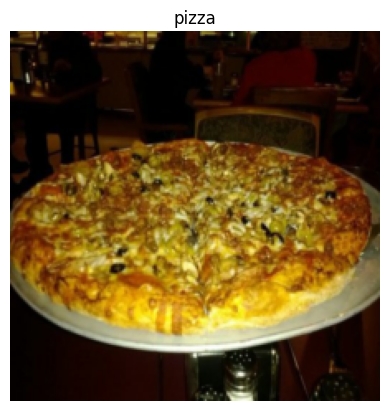

In [9]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

plt.imshow(image_temp.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label_temp])
plt.axis(False);

In [10]:
height = 224
width = 224
channel = 3
patch_size = 16

number_of_patches = (height * width) // (patch_size**2)
print(f"Number of patch images {number_of_patches}")

Number of patch images 196


In [11]:
image_dimension = (height, width, channel)
patch_dimension = (number_of_patches, patch_size**2 * channel)

print(f"Dimension of original images :{image_dimension}")
print(f"Dimension of patch images :{patch_dimension}")

Dimension of original images :(224, 224, 3)
Dimension of patch images :(196, 768)


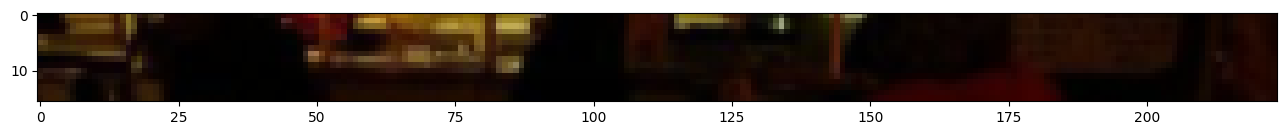

In [12]:
plt.figure(figsize=(patch_size, width))
plt.imshow(image_temp.permute(1, 2, 0)[:patch_size, :, :])

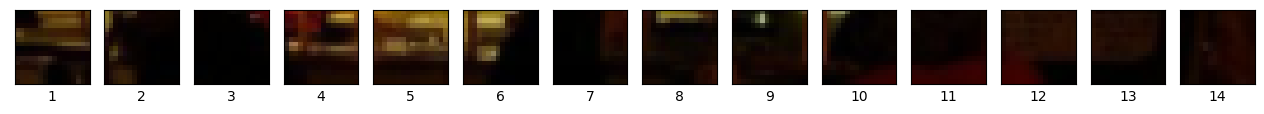

In [13]:
image_size = 224
patch_size = 16
assert image_size % patch_size == 0, "Image size must be divisible by patch size"

permuted_image = image_temp.permute(1, 2, 0)

fig, axes = plt.subplots(nrows=1, ncols=image_size // patch_size, figsize=(patch_size, patch_size))

for i, patch in enumerate(range(0, image_size, patch_size)):
    axes[i].imshow(permuted_image[:patch_size, patch:patch + patch_size, :])
    axes[i].set_xlabel(i + 1)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

In [14]:
image_size = 224
patch_size = 16
assert image_size % patch_size == 0, "Image size must be divisible by patch size"

number_patches = (image_size // patch_size)
fig, axes = plt.subplots(nrows=number_patches, ncols=number_patches, figsize=(image_size, image_size), sharex=True, sharey=True)

for i, patchx in enumerate(range(0, image_size, patch_size)):
    for j, patchy in enumerate(range(0, image_size, patch_size)):
        axes[i][j].imshow(permuted_image[patchx:patchx+patch_size, patchy:patchy+patch_size, :])
        axes[i][j].set_xlabel(i + 1, 
                              rotation="horizontal",
                              horizontalalignment="right",
                              verticalalignment="center")
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])
        axes[i][j].label_outer()
        

In [15]:
random_tensor = torch.randn((1, 3, 224, 224))
conv2d = nn.Conv2d(in_channels=3, out_channels=768, kernel_size=patch_size, stride=patch_size)


In [16]:
conv2d(random_tensor).shape

torch.Size([1, 768, 14, 14])

In [17]:
image_conv_out = conv2d(image_temp.unsqueeze(dim=0))
image_conv_out.shape

torch.Size([1, 768, 14, 14])

Output channel: 768


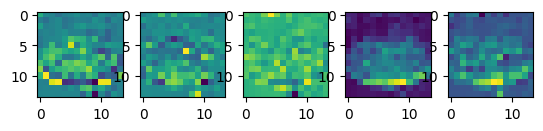

In [18]:
import random
k = 5
index_sample = random.sample(range(0, 768), k = k)

print(f"Output channel: {image_conv_out.shape[1]}")

fig, axes = plt.subplots(nrows=1, ncols=k)
for i, idx in enumerate(index_sample):
    image_out = image_conv_out.squeeze().detach().numpy()
    axes[i].imshow(image_out[idx, :, :])

In [19]:
flatten = nn.Flatten(start_dim=2, end_dim=3)
print(flatten(image_conv_out).permute(0, 2, 1).shape)

torch.Size([1, 196, 768])


# Patch Embedding Block

In [20]:
class PatchEmbeddingBlock(nn.Module):
    """
    A patch embedding block transforms a 2D image into sequence learnable 1D patch embedding.

    Default hyperparameter is based on ViT-Base model.
    in_channels:    Color channels of image. Defaults to 3.
    patch_size:     Size of each patches to convert image into. Defaults to 16.
    embedding_dim:  Embedding dimension that an image convert into. Defaults to 768.
    """
    
    def __init__(self, in_channels : int = 3, patch_size : int = 16, embedding_dim : int = 768):
        super().__init__()
        # Create a layer to turn an image into patches
        self.patch_conv2d = nn.Conv2d(in_channels=in_channels, 
                                      out_channels=embedding_dim, 
                                      kernel_size=patch_size, 
                                      stride=patch_size, 
                                      padding=0)

        # only flatten the feature map dimensions into a single vector
        self.flatten_layer = nn.Flatten(start_dim=2, end_dim=3)


    def forward(self, image: torch.Tensor):
        image_resolution = image.shape[-1]
        assert image_resolution % patch_size == 0, "Image size must be divisible by patch_size"

        image_patches = self.patch_conv2d(image)
        flattened_image = self.flatten_layer(image_patches)

        return flattened_image.permute(0, 2, 1)

In [21]:
from torchinfo import summary

embedding = PatchEmbeddingBlock()
summary(embedding)

Layer (type:depth-idx)                   Param #
PatchEmbeddingBlock                      --
├─Conv2d: 1-1                            590,592
├─Flatten: 1-2                           --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0

In [22]:
image_random = torch.randn((1, 3, 224, 224))
invalid_image = torch.randn((1, 3, 250, 250))

print(embedding(image_random))
print(embedding(invalid_image))

tensor([[[-0.1857,  0.8659, -1.3392,  ...,  0.0712,  0.5900,  0.3178],
         [-0.0180,  0.7125,  0.5378,  ...,  0.0633, -0.9302, -0.1411],
         [-0.4386, -0.7495, -0.3876,  ...,  0.0646,  0.0385, -0.7702],
         ...,
         [ 0.3887,  0.1563,  0.3170,  ...,  0.2660,  0.4821, -0.1316],
         [ 1.0678,  0.1898, -0.4269,  ..., -0.8341,  0.2008, -1.2878],
         [-0.2153,  0.0042,  0.6063,  ...,  0.5921, -0.5955,  0.3126]]],
       grad_fn=<PermuteBackward0>)


AssertionError: Image size must be divisible by patch_size

In [23]:
image_patches = embedding(image_random)
print(f"Image patch dimension: {image_patches.shape} -> [batch_size, number_of_patches, embedding_dimension]")

Image patch dimension: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [24]:
class_token = torch.ones((1, 1, 768,))
torch.cat((class_token, image_patches), dim=1).shape

torch.Size([1, 197, 768])

In [30]:
batch_size, _, embedding_dim = image_patches.shape

class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dim), requires_grad=True)
patch_embedding_with_class_token = torch.cat((class_token, image_patches), dim=1)

print(f"Image patches dimension: {image_patches.shape} -> [batch_size, number_of_patches, embedding_dim]")
print(f"Class token dimension: {class_token.shape} -> [batch_size, 1, embedding_dim]")
print(f"Patch embedding with class token dimension: {patch_embedding_with_class_token.shape} -> [batch_size, number_of_patches + 1, embedding_dim]")

Image patches dimension: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dim]
Class token dimension: torch.Size([1, 1, 768]) -> [batch_size, 1, embedding_dim]
Patch embedding with class token dimension: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches + 1, embedding_dim]


In [34]:
position_embedding = nn.Parameter(torch.ones(batch_size,
                                             number_of_patches + 1,
                                             embedding_dim), 
                                  requires_grad=True)
print(f"Position embedding dimension: {position_embedding.shape} -> [batch_size, number_of_patches + 1, embedding_dim]")

Position embedding dimension: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches + 1, embedding_dim]


In [37]:
torch.manual_seed(82)
torch.cuda.manual_seed(82)

batch_size = 1
image_size = 224
channel = 3
patch_size = 16
embedding_dim = patch_size ** 2 * channel
number_of_patches = (image_size // patch_size) ** 2

image = image_temp.unsqueeze(dim=0)

embedding_layer = PatchEmbeddingBlock(in_channels=channel, patch_size=patch_size, embedding_dim=embedding_dim)
embedding_patch_image = embedding_layer(image)
print(f"Embedding patch image without class dimension: {embedding_patch_image.shape} -> [batch_size, number_of_patches, embedding_dim]")


class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dim), requires_grad=True)
embedding_patch_image_with_class = torch.cat((embedding_patch_image, class_token), dim=1)
print(f"Embedding patch image with class dimension: {embedding_patch_image_with_class.shape} -> [batch_size, number_of_patches + 1, embedding_dim]")

position_embedding = nn.Parameter(torch.rand(batch_size, number_of_patches + 1, embedding_dim), requires_grad=True)
position_embedding_patch_image = embedding_patch_image_with_class + position_embedding
print(f"Position embedding tensor dimension: {position_embedding_patch_image.shape} -> [batch_size, number_of_patches + 1, embedding_dim]")

Embedding patch image without class dimension: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dim]
Embedding patch image with class dimension: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches + 1, embedding_dim]
Position embedding tensor dimension: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches + 1, embedding_dim]


torch.Size([3, 224, 224])